In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
import missingno
import dateutil
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm import LGBMRegressor
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.patches as patches
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot

import pandas as pd
import numpy as np
import io #used to read uploaded data
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pylab 
import scipy.stats as stats
import statsmodels.api as sm
from math import pi

from sklearn.preprocessing import LabelEncoder


import seaborn as sns
from sklearn.utils import shuffle
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
pd.options.mode.chained_assignment = None  # default='warn'

from imblearn.over_sampling import SMOTE

from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")

## Import Data

In [16]:
train_set = pd.read_csv('train.csv',delimiter =";")
test_set = pd.read_csv('test.csv',delimiter =";")
ids = test_set['claim_id']
test_set = test_set.set_index('claim_id')
train_set = train_set.set_index('claim_id')
train_set.head()

###############################################################
#                     Data cleaning
###############################################################


# number of delay 
train_set['claim_date_registered'] = pd.to_datetime(train_set['claim_date_registered'], format='%Y%m%d')
train_set['claim_date_occured'] = pd.to_datetime(train_set['claim_date_occured'], format='%Y%m%d')

train_set.loc[:,'num_of_delay_days'] = (train_set.loc[:,'claim_date_registered'] - 
                                        train_set.loc[:,'claim_date_occured'])

train_set.loc[:,'num_of_delay_days'] = train_set.loc[:,'num_of_delay_days']//np.timedelta64(1, 'D')

# alcohol_test
train_set['alcohol_test'] = np.where((train_set['claim_alcohol'] =='P')|(train_set['claim_alcohol'] =='N'), 'Yes', 'No')

# age of vehicle (***used reference year as 2017***)
end = 201712.0
train_set.loc[:,'age_of_vehicle'] = (end - train_set.loc[:,'claim_vehicle_date_inuse'])//100

# age of policyholder (***used reference year as 2017***)
reference_year = 2017.0
train_set.loc[:,'age_of_policyholder'] = (reference_year - train_set.loc[:,'policy_holder_year_birth'])

# expert_appointed (Yes -> if there was an expert appointed by the policyholder)
train_set['expert_appointed'] = np.where(train_set['policy_holder_expert_id'].isna(), 'Yes', 'No')

# age of driver (***used reference year as 2017***)
reference_year = 2017.0
train_set.loc[:,'age_of_driver'] = (reference_year - train_set.loc[:,'driver_year_birth'])

# Number of policy years (expiry date - start date)
train_set['policy_date_start'] = pd.to_datetime(train_set['policy_date_start'], format='%Y%m')
train_set['policy_date_next_expiry'] = pd.to_datetime(train_set['policy_date_next_expiry'], format='%Y%m')
train_set.loc[:,'policy_years'] = train_set.loc[:,'policy_date_next_expiry'] - train_set.loc[:,'policy_date_start']
train_set['policy_years'] = round(train_set['policy_years']/np.timedelta64(1, 'Y'),0)

# Renewed? (Missing -> No)
train_set['renewed'] = np.where(train_set['policy_date_last_renewed'].isna(), 'No', 'Yes')

# Repair performed? (Missing -> No)
train_set['repair_performed'] = np.where(train_set['repair_id'].isna(), 'No', 'Yes')

# third party involved?
train_set['tp_claim'] = np.where(train_set['third_party_1_id'].isna(),'N','Y')
# number of third party involved
a = train_set['third_party_1_id'].notna().astype(int)
b = train_set['third_party_2_id'].notna().astype(int)
c = train_set['third_party_3_id'].notna().astype(int)
train_set['n_tp'] = a + b + c 


# number of delay 
test_set['claim_date_registered'] = pd.to_datetime(test_set['claim_date_registered'], format='%Y%m%d')
test_set['claim_date_occured'] = pd.to_datetime(test_set['claim_date_occured'], format='%Y%m%d')
test_set.loc[:,'num_of_delay_days'] = (test_set.loc[:,'claim_date_registered']- test_set.loc[:,'claim_date_occured'])
test_set.loc[:,'num_of_delay_days'] = test_set.loc[:,'num_of_delay_days']//np.timedelta64(1, 'D')

# alcohol_test
test_set['alcohol_test'] = np.where((test_set['claim_alcohol'] =='P')|(test_set['claim_alcohol'] =='N'), 'Yes', 'No')

# age of vehicle (***used reference year as 2018***)
end = 201812.0
test_set.loc[:,'age_of_vehicle'] = (end - test_set.loc[:,'claim_vehicle_date_inuse'])//100

# age of policyholder (***used reference year as 2018***)
reference_year = 2018.0
test_set.loc[:,'age_of_policyholder'] = (reference_year - test_set.loc[:,'policy_holder_year_birth'])

# expert_appointed (Yes -> if there was an expert appointed by the policyholder)
test_set['expert_appointed'] = np.where(test_set['policy_holder_expert_id'].isna(), 'Yes', 'No')

# age of driver (***used reference year as 2018***)
reference_year = 2018.0
test_set.loc[:,'age_of_driver'] = (reference_year - test_set.loc[:,'driver_year_birth'])

# Number of policy years (expiry date - start date)
test_set['policy_date_start'] = pd.to_datetime(test_set['policy_date_start'], format='%Y%m')
test_set['policy_date_next_expiry'] = pd.to_datetime(test_set['policy_date_next_expiry'], format='%Y%m')
test_set.loc[:,'policy_years'] = test_set.loc[:,'policy_date_next_expiry'] - test_set.loc[:,'policy_date_start']
test_set['policy_years'] = round(test_set['policy_years']/np.timedelta64(1, 'Y'),0)

# Renewed? (Missing -> No)
test_set['renewed'] = np.where(test_set['policy_date_last_renewed'].isna(), 'No', 'Yes')

# Repair performed? (Missing -> No)
test_set['repair_performed'] = np.where(test_set['repair_id'].isna(), 'No', 'Yes')

# third party involved?
test_set['tp_claim'] = np.where(test_set['third_party_1_id'].isna(),'N','Y')
# number of third party involved
a = test_set['third_party_1_id'].notna().astype(int)
b = test_set['third_party_2_id'].notna().astype(int)
c = test_set['third_party_3_id'].notna().astype(int)
test_set['n_tp'] = a + b + c 



############################################
#          Missing Values                  #
############################################

train_set['claim_alcohol'].fillna('NA',inplace = True)
train_set['claim_language'].fillna('NA',inplace = True)
train_set['claim_vehicle_type'].fillna('NA',inplace = True)
train_set['claim_vehicle_brand'].fillna('others',inplace = True)
train_set['claim_vehicle_fuel_type'].fillna('NA',inplace = True)
train_set['policy_years'].fillna(0,inplace = True)

# Replacing missing values of claim_vehicle_cyl,claim_vehicle_load,claim_vehicle_power with mean based on type 
train_set["claim_vehicle_cyl"] = train_set.groupby(['claim_vehicle_type'])['claim_vehicle_cyl'].apply(lambda x: x.fillna(x.mean()))
train_set["claim_vehicle_load"] = train_set.groupby(['claim_vehicle_type'])['claim_vehicle_load'].apply(lambda x: x.fillna(x.mean()))
train_set["claim_vehicle_power"] = train_set.groupby(['claim_vehicle_type'])['claim_vehicle_power'].apply(lambda x: x.fillna(x.mean()))

# Replace the age of policyholder by mean (as there are no outliers)
train_set['age_of_policyholder'].fillna(train_set['age_of_policyholder'].mean(),inplace = True)

# Replace the policyholder postal code by mode (we can also delete the rows - only 111 - 0.13%)
train_set['policy_holder_postal_code'].fillna(int(train_set['policy_holder_postal_code'].mode()),inplace = True)

# Replace the driver postal code by mode (we can also delete the rows - only 73 - 0.08%)
train_set['driver_postal_code'].fillna(int(train_set['driver_postal_code'].mode()),inplace = True)

# Replace the age of driver by mean (as there are no outliers)
train_set['age_of_driver'].fillna(train_set['age_of_driver'].mean(),inplace = True)

# Replace policy_premium_100 with mean (no outliers)
train_set['policy_premium_100'].fillna(train_set['policy_premium_100'].mean(),inplace = True)

# Replace policy_coverage_1000 with median (there were outliers)
train_set['policy_coverage_1000'].fillna(train_set['policy_coverage_1000'].median(),inplace = True)

# Replace age_of_vehicle with median (there were outliers)
train_set['age_of_vehicle'].fillna(train_set['age_of_vehicle'].median(),inplace = True)



test_set['claim_alcohol'].fillna('NA',inplace = True)
test_set['claim_language'].fillna('NA',inplace = True)
test_set['claim_vehicle_type'].fillna('NA',inplace = True)
test_set['claim_vehicle_brand'].fillna('others',inplace = True)
test_set['claim_vehicle_fuel_type'].fillna('NA',inplace = True)
test_set['policy_years'].fillna(0,inplace = True)

# Replacing missing values of claim_vehicle_cyl,claim_vehicle_load,claim_vehicle_power with mean based on type 
test_set["claim_vehicle_cyl"] = test_set.groupby(['claim_vehicle_type'])['claim_vehicle_cyl'].apply(lambda x: x.fillna(x.mean()))
test_set["claim_vehicle_load"] = test_set.groupby(['claim_vehicle_type'])['claim_vehicle_load'].apply(lambda x: x.fillna(x.mean()))
test_set["claim_vehicle_power"] = test_set.groupby(['claim_vehicle_type'])['claim_vehicle_power'].apply(lambda x: x.fillna(x.mean()))

# Replace the age of policyholder by mean (as there are no outliers)
test_set['age_of_policyholder'].fillna(test_set['age_of_policyholder'].mean(),inplace = True)

# Replace the policyholder postal code by mode (we can also delete the rows - only 111 - 0.13%)
test_set['policy_holder_postal_code'].fillna(int(test_set['policy_holder_postal_code'].mode()),inplace = True)

# Replace the driver postal code by mode (we can also delete the rows - only 73 - 0.08%)
test_set['driver_postal_code'].fillna(int(test_set['driver_postal_code'].mode()),inplace = True)

# Replace the age of driver by mean (as there are no outliers)
test_set['age_of_driver'].fillna(test_set['age_of_driver'].mean(),inplace = True)

# Replace policy_premium_100 with mean (no outliers)
test_set['policy_premium_100'].fillna(test_set['policy_premium_100'].mean(),inplace = True)

# Replace policy_coverage_1000 with median (there were outliers)
test_set['policy_coverage_1000'].fillna(test_set['policy_coverage_1000'].median(),inplace = True)

# Replace age_of_vehicle with median (there were outliers)
test_set['age_of_vehicle'].fillna(test_set['age_of_vehicle'].median(),inplace = True)


##################################
# Deleting columns               #
##################################


# deleting columns --> claim_time_occurred(59% of the data missing)

columns_to_drop = ['claim_time_occured','claim_vehicle_date_inuse','policy_holder_expert_id','policy_holder_year_birth','driver_expert_id',
                   'driver_year_birth','driver_vehicle_id','third_party_1_id','third_party_1_form','third_party_1_country',
                   'third_party_1_vehicle_id','third_party_1_expert_id','third_party_2_id','third_party_2_country','third_party_2_form',
                   'third_party_2_vehicle_id','third_party_2_expert_id','third_party_3_id','third_party_3_form','third_party_3_country',
                   'third_party_3_vehicle_id','third_party_3_expert_id','policy_date_start','policy_date_next_expiry','policy_date_last_renewed',
                   'repair_id','repair_postal_code','repair_form','repair_year_birth','repair_country','third_party_1_postal_code','third_party_1_injured','third_party_1_vehicle_type','third_party_1_year_birth','third_party_2_postal_code',
                   'third_party_2_injured','third_party_2_vehicle_type','third_party_2_year_birth','third_party_3_postal_code',
                   'third_party_3_injured','third_party_3_vehicle_type','third_party_3_year_birth'
                   #,'policy_holder_id','driver_id'
                  ]
train_set = train_set.drop(columns = columns_to_drop, axis = 1)


# deleting columns
#columns_to_drop = ['claim_time_occured','claim_vehicle_date_inuse','policy_holder_expert_id','policy_holder_year_birth','driver_expert_id',
#                   'driver_year_birth','driver_vehicle_id','third_party_1_id','third_party_1_form','third_party_1_country',
#                   'third_party_1_vehicle_id','third_party_1_expert_id','third_party_2_id','third_party_2_country','third_party_2_form',
#                   'third_party_2_vehicle_id','third_party_2_expert_id','third_party_3_id','third_party_3_form','third_party_3_country',
#                   'third_party_3_vehicle_id','third_party_3_expert_id','policy_date_start','policy_date_next_expiry','policy_date_last_renewed',
#                   'repair_id','repair_postal_code','repair_form','repair_year_birth','repair_country','third_party_1_postal_code','third_party_1_injured','third_party_1_vehicle_type','third_party_1_year_birth','third_party_2_postal_code',
#                   'third_party_2_injured','third_party_2_vehicle_type','third_party_2_year_birth','third_party_3_postal_code',
#                   'third_party_3_injured','third_party_3_vehicle_type','third_party_3_year_birth'
                   #'policy_holder_id','driver_id'
#                  ]
test_set = test_set.drop(columns = columns_to_drop,axis =1)


# drop when more than 50%

#columns_to_drop = ['claim_time_occured','claim_alcohol','policy_holder_expert_id','third_party_1_year_birth',
#                   'third_party_1_expert_id','third_party_2_id','third_party_2_postal_code','third_party_2_injured',
#                   'third_party_2_vehicle_type','third_party_2_form','third_party_2_year_birth',
#                   'third_party_2_country','third_party_2_vehicle_id','third_party_2_expert_id','third_party_3_id',
#                   'third_party_3_postal_code','third_party_3_injured','third_party_3_vehicle_type',
#                   'third_party_3_form','third_party_3_year_birth','third_party_3_country','third_party_3_vehicle_id',
#                   'third_party_3_expert_id','repair_year_birth']

#train_set = train_set.drop(columns = columns_to_drop, axis = 1)

#test_set = test_set.drop(columns = columns_to_drop,axis =1)



#################################
#     Outliers                #
################################


# remove outliers
train_set = train_set.loc[train_set['age_of_vehicle'] > 0]
train_set = train_set.loc[train_set['age_of_policyholder']<90]
train_set = train_set.loc[train_set['age_of_driver']<90]
# claim amount datatype from string to float
train_set['claim_amount'] = train_set['claim_amount'].str.replace("'","")
train_set['claim_amount'] = train_set['claim_amount'].str.replace(",",".")
train_set['claim_amount'] = train_set['claim_amount'].astype(float)
# fraud code to 1 and 0
train_set['fraud'] = train_set['fraud'].map({'Y':1,'N':0})
# converting date variables to string
train_set['claim_date_registered'] = train_set['claim_date_registered'].astype(str)
train_set['claim_date_occured'] = train_set['claim_date_occured'].astype(str)
train_set['claim_postal_code'] = train_set['claim_postal_code'].astype(str)
train_set['policy_holder_postal_code'] = train_set['policy_holder_postal_code'].astype(str)
train_set['driver_postal_code'] = train_set['driver_postal_code'].astype(str)
train_set['claim_language'] = train_set['claim_language'].astype(str)
train_set['claim_vehicle_fuel_type'] = train_set['claim_vehicle_fuel_type'].astype(str)
train_set['claim_vehicle_id'] = train_set['claim_vehicle_id'].astype(str)
#train_set['policy_date_start'] = train_set['policy_date_start'].astype(str)
#train_set['policy_date_next_expiry'] = train_set['policy_date_next_expiry'].astype(str)



# converting date variables to string
test_set['claim_date_registered'] = test_set['claim_date_registered'].astype(str)
test_set['claim_date_occured'] = test_set['claim_date_occured'].astype(str)
test_set['claim_postal_code'] = test_set['claim_postal_code'].astype(str)
test_set['policy_holder_postal_code'] = test_set['policy_holder_postal_code'].astype(str)
test_set['driver_postal_code'] = test_set['driver_postal_code'].astype(str)
test_set['claim_language'] = test_set['claim_language'].astype(str)
test_set['claim_vehicle_fuel_type'] = test_set['claim_vehicle_fuel_type'].astype(str)
test_set['claim_vehicle_id'] = test_set['claim_vehicle_id'].astype(str)
#test_set['policy_date_start'] = test_set['policy_date_start'].astype(str)
#test_set['policy_date_next_expiry'] = test_set['policy_date_next_expiry'].astype(str)

dataset_train = train_set.copy()

## Label encode

In [17]:
cat_features = [x for x in dataset_train.columns if dataset_train[x].dtype == 'object']

for c in cat_features:
  lbl = LabelEncoder()
  lbl.fit(list(dataset_train[c].values))
  dataset_train[c] = lbl.transform(list(dataset_train[c].values))

In [18]:
cat_features = [x for x in test_set.columns if test_set[x].dtype == 'object']

for c in cat_features:
  lbl = LabelEncoder()
  lbl.fit(list(test_set[c].values))
  test_set[c] = lbl.transform(list(test_set[c].values))

## Split data

In [39]:
# split trainset
X = dataset_train.drop('fraud',axis = 1)
X = X.drop('claim_amount', axis=1)
Y = dataset_train['fraud']
# split into train and validation set
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.30,stratify = Y,random_state=100)

# Default Light GBM

In [40]:
train_data = lgb.Dataset(xtrain, label=ytrain)
test_data = lgb.Dataset(xtest, label=ytest)

In [21]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    #'max_bin': 255,
    'metric': 'auc',
    #'is_unbalance': 'true',
    'boosting': 'gbdt',
    #'num_leaves': 40,
    #'feature_fraction': 0.1,
    #'bagging_fraction': 0.7,
    #'bagging_freq': 1,
    #'learning_rate': 0.01,
    #'min_data_in_leaf':100,
    #'min_child_weight': 5,
    #'max_depth': 6,
    'verbose': 0
}

model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

y_pred = model.predict(xtest, num_iteration=model.best_iteration)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, ytest)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(ytest, y_pred)))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.759478
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.747147
[3]	valid_0's auc: 0.71691
[4]	valid_0's auc: 0.737751
[5]	valid_0's auc: 0.735795
[6]	valid_0's auc: 0.736063
[7]	valid_0's auc: 0.732356
[8]	valid_0's auc: 0.742977
[9]	valid_0's auc: 0.749538
[10]	valid_0's auc: 0.747262
[11]	valid_0's auc: 0.747746
[12]	valid_0's auc: 0.756553
[13]	valid_0's auc: 0.766261


[268]	valid_0's auc: 0.810439
[269]	valid_0's auc: 0.809883
[270]	valid_0's auc: 0.809868
[271]	valid_0's auc: 0.809247
[272]	valid_0's auc: 0.80883
Early stopping, best iteration is:
[172]	valid_0's auc: 0.815829
LightGBM Model accuracy score: 0.9948
Confusion matrix

 [[16501    13]
 [   73    19]]

True Positives(TP) =  16501

True Negatives(TN) =  19

False Positives(FP) =  13

False Negatives(FN) =  73


In [301]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    #'max_bin': 255,
    'metric': 'auc',
    #'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 32,
    'feature_fraction': 0.56,
    'bagging_fraction': 0.8,
    #'bagging_freq': 1,
    'learning_rate': 0.01,
    #'min_data_in_leaf':100,
    'min_child_weight': 5,
    'max_depth': 9,
    'verbose': 0,
    'lambda_l1': 0.12,
    'lambda_l2': 0.63
    
}

model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

y_pred = model.predict(xtest, num_iteration=model.best_iteration)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, ytest)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(ytest, y_pred)))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.743991
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further spli

[73]	valid_0's auc: 0.860324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's auc: 0.860327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's auc: 0.861209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's auc: 0.86107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's auc: 0.86222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's auc: 0.862228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's auc: 0.86311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's auc: 0.863136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's auc: 0.864094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	valid_0's auc: 0.864122
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's auc: 0.874332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's auc: 0.874505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's auc: 0.874612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's auc: 0.874667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's auc: 0.874951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's auc: 0.875582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's auc: 0.875717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's auc: 0.87559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's auc: 0.875898
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's auc: 0.879353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's auc: 0.879234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's auc: 0.879588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's auc: 0.879877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's auc: 0.879718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's auc: 0.8796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	valid_0's auc: 0.879711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	valid_0's auc: 0.880308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[249]	valid_0's auc: 0.880206
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[330]	valid_0's auc: 0.885929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[331]	valid_0's auc: 0.886095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[332]	valid_0's auc: 0.886339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[333]	valid_0's auc: 0.886339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[334]	valid_0's auc: 0.886232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[335]	valid_0's auc: 0.88636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	valid_0's auc: 0.886553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	valid_0's auc: 0.886553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	valid_0's auc: 0.886513
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[414]	valid_0's auc: 0.885746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[415]	valid_0's auc: 0.885855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[416]	valid_0's auc: 0.885764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[417]	valid_0's auc: 0.885818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[418]	valid_0's auc: 0.885781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[419]	valid_0's auc: 0.885764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[420]	valid_0's auc: 0.885525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[421]	valid_0's auc: 0.885785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[422]	valid_0's auc: 0.885764
[LightGBM] [Warning] No further splits with positive ga

<AxesSubplot:>

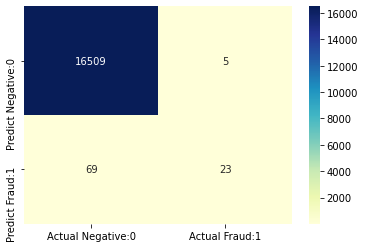

In [300]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0', 'Actual Fraud:1'], 
                                 index=['Predict Negative:0', 'Predict Fraud:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')



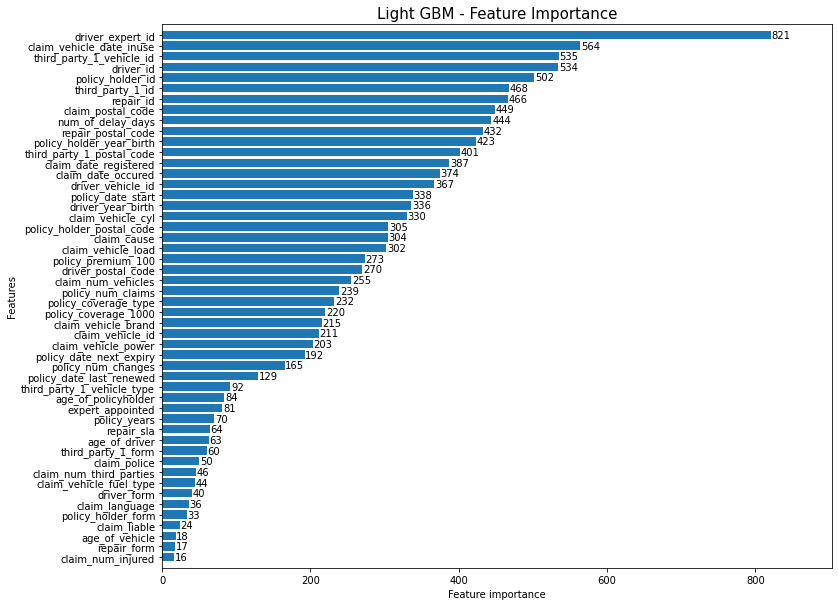

In [295]:
fig,ax = plt.subplots(figsize = (12,10))
lgb.plot_importance(model,max_num_features = 50,height = 0.8,ax = ax)
ax.grid(False)
plt.title("Light GBM - Feature Importance", fontsize = 15)
plt.show()

In [34]:
#from sklearn.feature_selection import RFE
#model = LGBMClassifier()
#model.fit(xtrain,ytrain)
#yhat = model.predict(xtest)
#selector = RFE(clf, n_features_to_select=5, step=1)
#selector = selector.fit(xtrain, ytrain)
#selector.ranking_

In [35]:
#for i in range(xtrain.shape[1]):
#    print('Column: %d, Selected %s, Rank: %.3f' % (i, selector.support_[i], selector.ranking_[i]))

# Default LightGBM ROC Curve

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


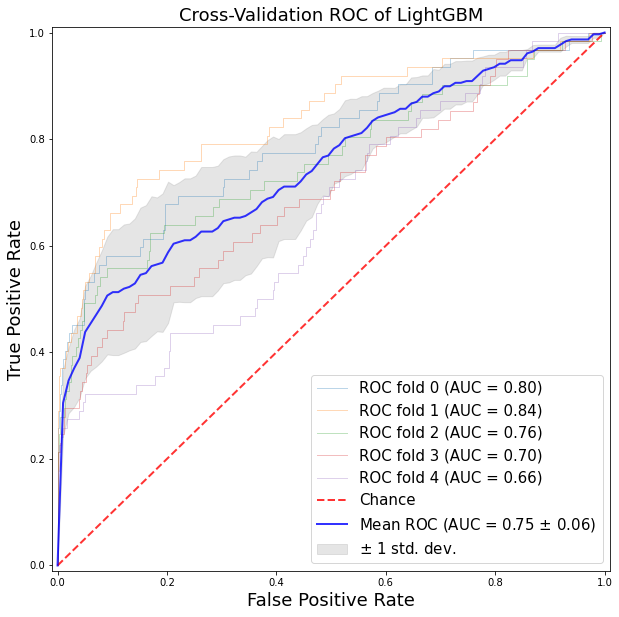

In [22]:
cv = StratifiedKFold(n_splits=5,shuffle=False)

clf = LGBMClassifier(
    objective = 'binary',
    #max_bin = 255,
    #metric = 'auc',
    #'is_unbalance'= 'true',
    boosting= 'gbdt',
    #num_leaves= 44,
    #'feature_fraction'= 0.1,
    #'bagging_fraction'= 0.7,
    #bagging_freq = 1,
    #learning_rate = 0.01,
    #min_data_in_leaf = 100,
    #min_child_weight = 5,
    #max_depth= 6,
    #num_boost_round=5000
    #verbose = 0
    )




x = dataset_train.drop('fraud',axis = 1)
x = x.drop('claim_amount', axis=1)
y = dataset_train['fraud']



tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(x, y):
    probas_ = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of LightGBM',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

# SVM ROC CURVE

In [24]:
from sklearn.svm import SVC

In [25]:
clf = SVC(kernel='linear', probability= True)

KeyboardInterrupt: 

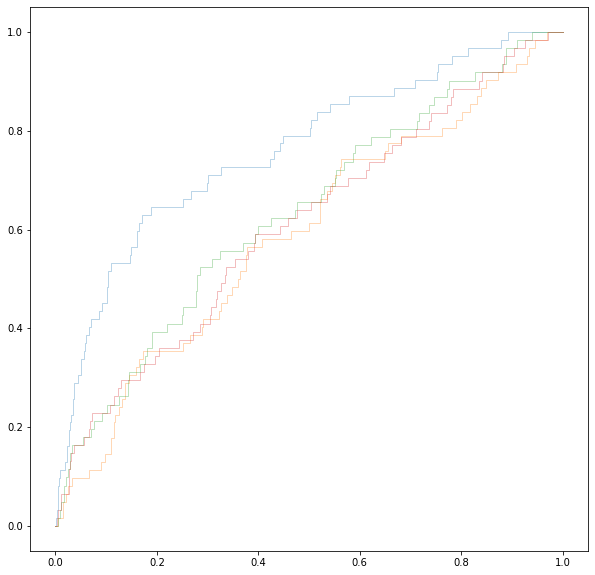

In [32]:
from sklearn.preprocessing import MinMaxScaler

cv = StratifiedKFold(n_splits=5,shuffle=False)

x = dataset_train.drop('fraud',axis = 1)
x = x.drop('claim_amount', axis=1)
y = dataset_train['fraud']

scaling = MinMaxScaler(feature_range=(-1,1)).fit(x)
x = pd.DataFrame(scaling.transform(x))

clf = SVC(kernel='linear', probability= True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(x, y):
    probas_ = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of SVM',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [ ]:
# split trainset
X = dataset_train.drop('fraud',axis = 1)
X = X.drop('claim_amount', axis=1)
Y = dataset_train['fraud']
# split into train and validation set
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.30,stratify = Y,random_state=100)

# Random Forest ROC curve

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
clf = RandomForestClassifier(n_estimators=200, random_state=0)

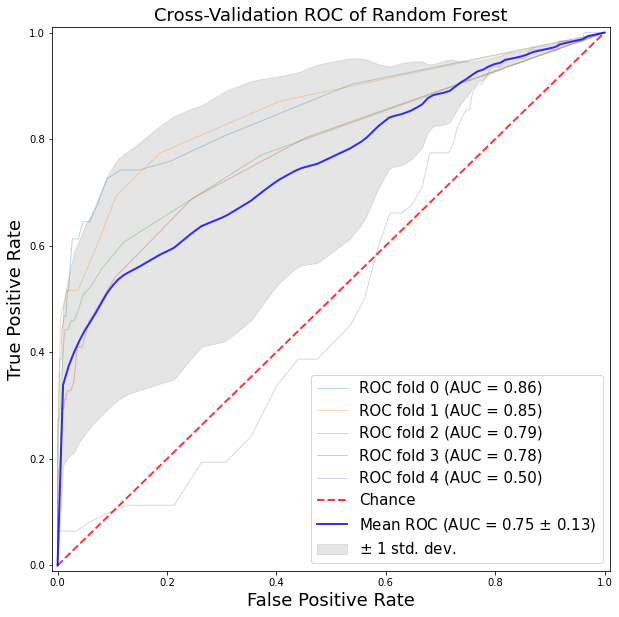

In [9]:
clf = RandomForestClassifier(n_estimators=200, random_state=0)

cv = StratifiedKFold(n_splits=5,shuffle=False)

x = dataset_train.drop('fraud',axis = 1)
x = x.drop('claim_amount', axis=1)
y = dataset_train['fraud']



tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(x, y):
    probas_ = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Random Forest',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

# Logistic Regression ROC Curve

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
clf = LogisticRegression(random_state=0, solver='lbfgs')

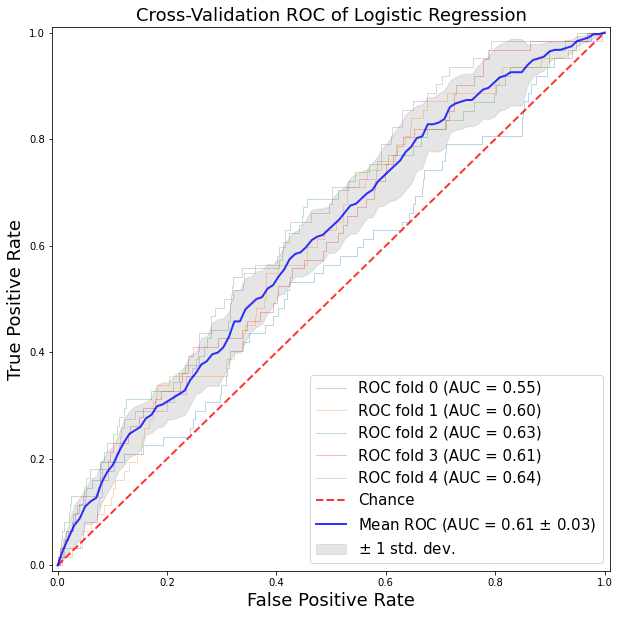

In [29]:
cv = StratifiedKFold(n_splits=5,shuffle=False)

clf = LogisticRegression(random_state=0, solver='lbfgs')

x = dataset_train.drop('fraud',axis = 1)
x = x.drop('claim_amount', axis=1)
y = dataset_train['fraud']



tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(x, y):
    probas_ = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Logistic Regression',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

# Default Precision Recall Curve

## Default LightGBM

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Logistic: f1=0.312 auc=0.224


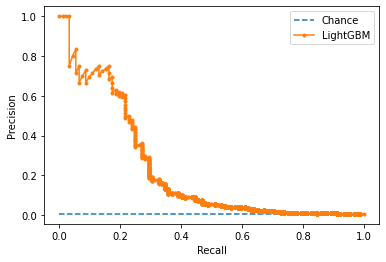

In [43]:
clf = LGBMClassifier(
    objective = 'binary',
    #max_bin = 255,
    #metric = 'auc',
    #'is_unbalance'= 'true',
    boosting= 'gbdt',
    #num_leaves= 44,
    #'feature_fraction'= 0.1,
    #'bagging_fraction'= 0.7,
    #bagging_freq = 1,
    #learning_rate = 0.01,
    #min_data_in_leaf = 100,
    #min_child_weight = 5,
    #max_depth= 6,
    #num_boost_round=5000
    #verbose = 0
    )


clf.fit(xtrain, ytrain)

lr_probs = clf.predict_proba(xtest)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = clf.predict(xtest)
lr_precision, lr_recall, _ = precision_recall_curve(ytest, lr_probs)
lr_f1, lr_auc = f1_score(ytest, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(ytest[ytest==1]) / len(ytest)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Chance')
pyplot.plot(lr_recall, lr_precision, marker='.', label='LightGBM')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## SVM

Logistic: f1=0.000 auc=0.010


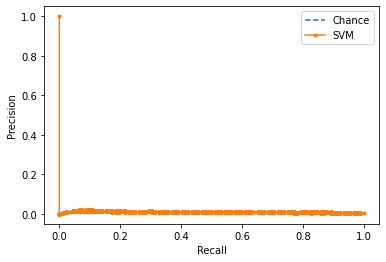

In [37]:

x = dataset_train.drop('fraud',axis = 1)
x = x.drop('claim_amount', axis=1)
y = dataset_train['fraud']

scaling = MinMaxScaler(feature_range=(-1,1)).fit(x)
x = pd.DataFrame(scaling.transform(x))

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 0.30,stratify = y,random_state=100)


clf = SVC(kernel='linear', probability= True)

clf.fit(xtrain, ytrain)

lr_probs = clf.predict_proba(xtest)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = clf.predict(xtest)
lr_precision, lr_recall, _ = precision_recall_curve(ytest, lr_probs)
lr_f1, lr_auc = f1_score(ytest, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(ytest[ytest==1]) / len(ytest)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Chance')
pyplot.plot(lr_recall, lr_precision, marker='.', label='SVM')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# split trainset
X = dataset_train.drop('fraud',axis = 1)
X = X.drop('claim_amount', axis=1)
Y = dataset_train['fraud']
# split into train and validation set
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.30,stratify = Y,random_state=100)

## Logistic Regression

Logistic: f1=0.043 auc=0.108


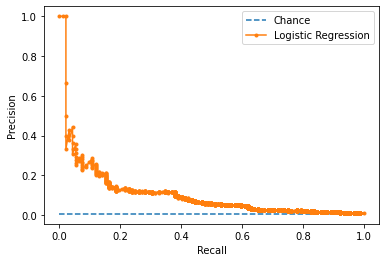

In [33]:
clf = LogisticRegression(random_state=0, solver='lbfgs')

clf.fit(xtrain, ytrain)

lr_probs = clf.predict_proba(xtest)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = clf.predict(xtest)
lr_precision, lr_recall, _ = precision_recall_curve(ytest, lr_probs)
lr_f1, lr_auc = f1_score(ytest, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(ytest[ytest==1]) / len(ytest)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Chance')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Random forest

Logistic: f1=0.083 auc=0.251


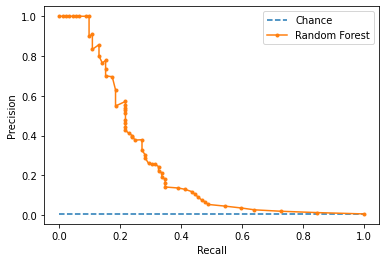

In [44]:
clf = RandomForestClassifier(n_estimators=200, random_state=0)

clf.fit(xtrain, ytrain)

lr_probs = clf.predict_proba(xtest)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = clf.predict(xtest)
lr_precision, lr_recall, _ = precision_recall_curve(ytest, lr_probs)
lr_f1, lr_auc = f1_score(ytest, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(ytest[ytest==1]) / len(ytest)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Chance')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [45]:
y_pred = clf.predict(xtest)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, ytest)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(ytest, y_pred)))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

LightGBM Model accuracy score: 0.9947
Confusion matrix

 [[16514     0]
 [   88     4]]

True Positives(TP) =  16514

True Negatives(TN) =  4

False Positives(FP) =  0

False Negatives(FN) =  88


# Finito